In [1]:
"""!pip3 install fcapy[all]
!pip3 install frozendict
!pip3 install ipynb
!pip3 install sparselinear
!pip3 install bitsets
!pip3 install bitarray
import torch
!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git"""

'!pip3 install fcapy[all]\n!pip3 install frozendict\n!pip3 install ipynb\n!pip3 install sparselinear\n!pip3 install bitsets\n!pip3 install bitarray\nimport torch\n!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git'

# Import libs

In [2]:
import numpy as np
import pandas as pd

In [3]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [5]:
import neural_lib as nl

In [6]:
df = pd.read_csv('./data.csv', index_col=0)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,1
2,F,Flight,4,5,216,2,low,M,59,3088,1
3,A,Flight,2,2,183,4,low,M,48,3374,1
4,B,Flight,3,3,176,4,medium,M,10,1177,1
5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [7]:
df.shape

(10999, 11)

In [8]:
df['Reached.on.Time_Y.N'].describe()

count    10999.000000
mean         0.596691
std          0.490584
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Reached.on.Time_Y.N, dtype: float64

# Pipeline

# Step 0. Binarize the data

In [9]:
df_bin = pd.DataFrame()
df_bin['Customer_care_calls>0'] = df['Customer_care_calls'] > 0
df_bin['Customer_care_calls=0'] = df['Customer_care_calls'] == 0
df_bin['Customer_rating>0'] = df['Customer_care_calls'] > 0
df_bin['Customer_rating=0'] = df['Customer_care_calls'] == 0
df_bin['Prior_purchases>0'] = df['Customer_care_calls'] > 0
df_bin['Prior_purchases=0'] = df['Customer_care_calls'] == 0
df_bin['Reached_on_time'] = df['Reached.on.Time_Y.N'] == 0
df_bin.head()

,Customer_care_calls>0,Customer_care_calls=0,Customer_rating>0,Customer_rating=0,Prior_purchases>0,Prior_purchases=0,Reached_on_time
ID,,,,,,,
1,True,False,True,False,True,False,False
2,True,False,True,False,True,False,False
3,True,False,True,False,True,False,False
4,True,False,True,False,True,False,False
5,True,False,True,False,True,False,False


In [10]:
df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,Customer_care_calls>0,Customer_care_calls=0,Customer_rating>0,Customer_rating=0,Prior_purchases>0,Prior_purchases=0,Reached_on_time
id,,,,,,,
h2576,True,False,True,False,True,False,False


Split the data to train and test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

In [12]:
y_feat = 'Reached_on_time'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

In [13]:
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

In [14]:
X_train.sample()

,Customer_care_calls>0,Customer_care_calls=0,Customer_rating>0,Customer_rating=0,Prior_purchases>0,Prior_purchases=0
id,,,,,,
h7218,True,False,True,False,True,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [15]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (7699 objects, 6 attributes, 23097 connections)
      |Customer_care_calls>0|Customer_care_calls=0|Customer_rating>0|Customer_rating=0|Prior_purchases>0|Prior_purchases=0|
h1589 |                    X|                     |                X|                 |                X|                 |
h10175|                    X|                     |                X|                 |                X|                 |
h326  |                    X|                     |                X|                 |                X|                 |
h10059|                    X|                     |                X|                 |                X|                 |
h463  |                    X|                     |                X|                 |                X|                 |
h1722 |                    X|                     |                X|                 |                X|                 |
h9790 |                    X|                     |                X| 

In [16]:
%%time 
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: user 62.6 ms, sys: 1.88 ms, total: 64.5 ms
Wall time: 63.9 ms


2

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [17]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [18]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [19]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [20]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [21]:
"""vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)

for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])"""

'vis.init_mover_per_poset(cn.poset)\nmvr = vis.mover\nfor a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:\n    mvr.swap_nodes(a, b)\n\nfor nodes, vert in [\n    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)\n]:\n    for a in nodes:\n        mvr.place_node(a, mvr.posx[vert])'

In [29]:
descr = {'(10;20]'}

traced = cn.trace_description(descr, include_targets=False)

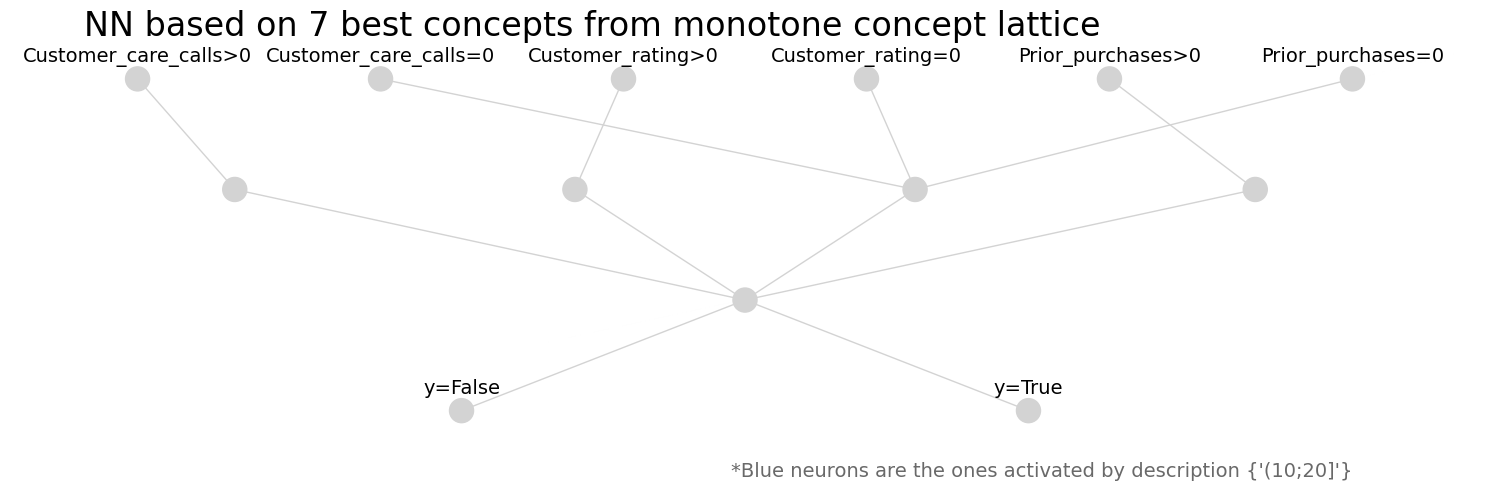

In [30]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [24]:
cn.fit(X_train, y_train)

To obtain the prediction

In [25]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [0 0 0 0 0 0 0 0 0 0]
Class prediction with probabilities [[0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]
 [0.70885557 0.2911444 ]]
True class [False  True False False  True  True  True  True  True False]


In [26]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))
print(classification_report(y_test.values.astype('int'), y_pred))

Recall score: 0.0
F1     score: 0.0
Accuracy score: 0.5821212121212122
              precision    recall  f1-score   support

           0       0.58      1.00      0.74      1921
           1       0.00      0.00      0.00      1379

    accuracy                           0.58      3300
   macro avg       0.29      0.50      0.37      3300
weighted avg       0.34      0.58      0.43      3300



/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Let us look at the fitted weights of edges

In [27]:
edge_weights = cn.edge_weights_from_network()

/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:653.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


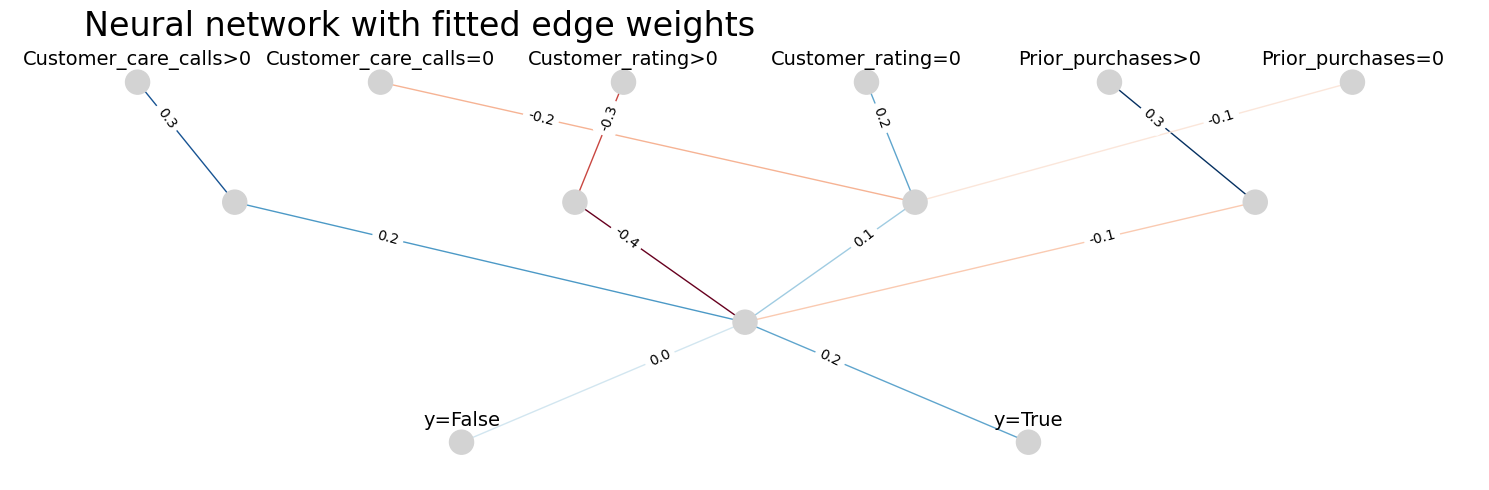

In [28]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()